### Day 37 主要講解的部分包含:
* 網絡主架構(inference)
    *卷積函數(conv2d)    
    *激活函數(leaky_relu)    
    *全連接層函數(local)    
        
大家可以先試著跑這一個範例code，    
透過model_summary()，     
可以看到模型各層的組成，也能看到數據經過每一層後輸出的數據維度，    
並找到\yolo\net\yolo_net.py     
看
網絡主架構(inference)
    卷積函數(conv2d)    
    激活函數(leaky_relu)    
    全連接層函數(local)    
        
開始吧~

ps: 如果有哪邊卡住了，先跳過去，先找出大架構，再慢慢理解。

輸入所需的library，這邊會呼叫到其他的程式碼(YoloNet.py)，

In [1]:
from yolo.net.yolo_tiny_net import YoloTinyNet 
from yolo.net.yolo_net import YoloNet 
import tensorflow as tf 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]


Using TensorFlow backend.


讀入資料集

In [2]:
img = cv2.imread("dog.jpg") # 讀取範例圖片
h, w, _ = img.shape
print(img.shape)
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # plt.imshow 預設圖片是 rgb 的
    plt.show()

(576, 768, 3)


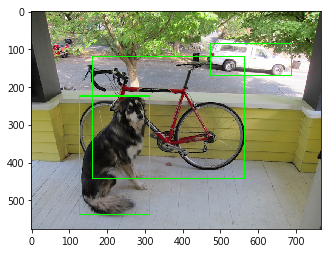

In [3]:
boxes = np.array([[128, 224, 314, 537], [475, 85, 689, 170], [162, 119, 565, 441]]).astype(float)
# 把 bboxes 坐標以原圖的 resolution normalize 到 0~1 之間
boxes[:, [0, 2]] = boxes[:, [0, 2]] / img.shape[1]
boxes[:, [1, 3]] = boxes[:, [1, 3]] / img.shape[0]

img_show = img.copy()
for x1, y1, x2, y2 in boxes:
    cv2.rectangle(img_show, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (0, 255, 0), 2)
show(img_show)

In [4]:
#輸出層解碼
def process_predicts(predicts):
  p_classes = predicts[0, :, :, 0:20]
  C = predicts[0, :, :, 20:22]
  coordinate = predicts[0, :, :, 22:]

  p_classes = np.reshape(p_classes, (7, 7, 1, 20))
  C = np.reshape(C, (7, 7, 2, 1))

  #對應相乘，產生𝑝(〖𝐶𝑙𝑎𝑠𝑠〗_𝑗 |𝑜𝑏𝑗𝑒𝑐𝑡)*𝑃(𝑜𝑏𝑗𝑒𝑐𝑡)
  P = C * p_classes
  index = np.argmax(P)

  index = np.unravel_index(index, P.shape)

  class_num = index[3]

  coordinate = np.reshape(coordinate, (7, 7, 2, 4))

  max_coordinate = coordinate[index[0], index[1], index[2], :]

  xcenter = max_coordinate[0]
  ycenter = max_coordinate[1]
  w = max_coordinate[2]
  h = max_coordinate[3]

  xcenter = (index[1] + xcenter) * (448/7.0)
  ycenter = (index[0] + ycenter) * (448/7.0)

  w = w * 448
  h = h * 448

  xmin = xcenter - w/2.0
  ymin = ycenter - h/2.0

  xmax = xmin + w
  ymax = ymin + h

  return xmin, ymin, xmax, ymax, class_num

### 設定YoloNet 所需的超參數

In [5]:
common_params = {'image_size': 448, 'num_classes': 20, 
                'batch_size':1}
net_params = {'cell_size': 7, 'boxes_per_cell':2, 'weight_decay': 0.0005, 'class_scale': 2.0,
'object_scale':1.0, 'noobject_scale': 0.5, 'coord_scale': 5.0}

#net = YoloTinyNet(common_params, net_params, test=False)
net = YoloNet(common_params, net_params, test=False)

# Tensorflow 如果想如果想要從外部傳入data,那就要用到 tf.placeholder()，然後以這種形式傳輸數據， sess.run(***,feed_dict={input: **})
# 傳值的工作交給 sess.run(),需要傳入的值放在 feed_dict={}，一一對應每一個 input, placeholder和 feed_dict={}是綁定在一出現的。 
image = tf.placeholder(tf.float32, (1, 448, 448, 3))
predicts = net.inference(image)

通過這些參數，可以看到模型各層的組成，也能看到數據經過每一層後輸出的數據維度，
還能看到參數數量是怎麼算出來的。
透過model_summary()就可以囉~

In [6]:
import tensorflow.contrib.slim as slim
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

---------
Variables: name (type shape) [size]
---------
conv1/weights:0 (float32_ref 7x7x3x64) [9408, bytes: 37632]
conv1/biases:0 (float32_ref 64) [64, bytes: 256]
conv2/weights:0 (float32_ref 3x3x64x192) [110592, bytes: 442368]
conv2/biases:0 (float32_ref 192) [192, bytes: 768]
conv3/weights:0 (float32_ref 1x1x192x128) [24576, bytes: 98304]
conv3/biases:0 (float32_ref 128) [128, bytes: 512]
conv4/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
conv4/biases:0 (float32_ref 256) [256, bytes: 1024]
conv5/weights:0 (float32_ref 1x1x256x256) [65536, bytes: 262144]
conv5/biases:0 (float32_ref 256) [256, bytes: 1024]
conv6/weights:0 (float32_ref 3x3x256x512) [1179648, bytes: 4718592]
conv6/biases:0 (float32_ref 512) [512, bytes: 2048]
conv7/weights:0 (float32_ref 1x1x512x256) [131072, bytes: 524288]
conv7/biases:0 (float32_ref 256) [256, bytes: 1024]
conv8/weights:0 (float32_ref 3x3x256x512) [1179648, bytes: 4718592]
conv8/biases:0 (float32_ref 512) [512, bytes: 2048]
conv9/weig